In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [20]:
# Physics parameters 
Te = 3          # Constant electron temperature
A0 = 1/np.pi
eta= 1.0e-8

# Numerical settings
L  = np.sqrt(2) # Length of the simulation region
n  = 200        # numebr of grids
ng = 2          # number of ghost grids for 5-points central scheme
h  = L/n        # unit size 
T  = 3.0        # simulation time
nt = 3000        # number of time steps
dt = T/nt       # time step

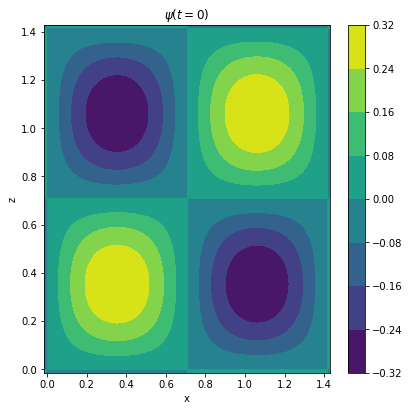

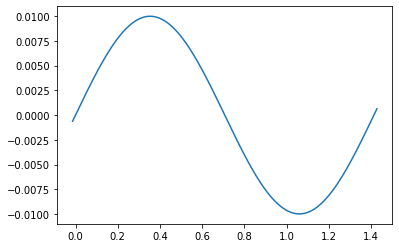

In [29]:
# Initial condition
rho1 = np.ones([n+2*ng+1, n+2*ng+1])  # Initial density
vx1  = np.zeros([n+2*ng+1, n+2*ng+1])
vz1  = np.zeros([n+2*ng+1, n+2*ng+1])
psi1 = np.zeros([n+2*ng+1, n+2*ng+1])

for i in range(n+1):
    for j in range(n+1):
        x = j*h 
        z = i*h 
        psi1[i+2,j+2] = A0*np.sin(2*np.pi*x/L)*np.sin(2*np.pi*z/L)

# Doubly-preriodic BC       
# Top
rho1[0]    = rho1[-5]
rho1[1]    = rho1[-4]
psi1[0]    = psi1[-5]
psi1[1]    = psi1[-4]
vx1[0]     = vx1[-5]
vx1[1]     = vx1[-4]
vz1[0]     = vz1[-5]
vz1[1]     = vz1[-4]
# Bottom 
rho1[-2]   = rho1[3]
rho1[-1]   = rho1[4]
psi1[-2]   = psi1[3]
psi1[-1]   = psi1[4]
vx1[-2]    = vx1[3]
vx1[-1]    = vx1[4]
vz1[-2]    = vz1[3]
vz1[-1]    = vz1[4]
# Left 
rho1[:,0]  = rho1[:,-5]  
rho1[:,1]  = rho1[:,-4]  
psi1[:,0]  = psi1[:,-5] 
psi1[:,1]  = psi1[:,-4]
vx1[:,0]   = vx1[:,-5]  
vx1[:,1]   = vx1[:,-4]  
vz1[:,0]   = vz1[:,-5] 
vz1[:,1]   = vz1[:,-4]
# Right 
rho1[:,-2] = rho1[:,3]
rho1[:,-1] = rho1[:,4]
psi1[:,-2] = psi1[:,3]
psi1[:,-1] = psi1[:,4]
vx1[:,-2]  = vx1[:,3]
vx1[:,-1]  = vx1[:,4]
vz1[:,-2]  = vz1[:,3]
vz1[:,-1]  = vz1[:,4]

plt.figure(figsize=[6.4,6.4])
x = np.linspace(0-2*h, L+2*h, n+5)
z = np.linspace(0-2*h, L+2*h, n+5)
cont = plt.contourf(x, z, psi1)
cbar = plt.colorbar(cont)
plt.xlabel('x')
plt.ylabel('z')
plt.title(r'$\psi(t=0)$')
#plt.savefig('psi0.png')

plt.figure()
plt.plot(z, psi1[:,3])

In [30]:
# 1st-order partial derivatives
def px(f, dx):
    return (-f[2:-2,4:]+8*f[2:-2,3:-1]-8*f[2:-2,1:-3]+f[2:-2,:-4]) / (12*dx)

def pz(f, dz):
    return (-f[4:,2:-2]+8*f[3:-1,2:-2]-8*f[1:-3,2:-2]+f[:-4,2:-2]) / (12*dz)

# 2nd-order partial derivatives
def pxx(f, dx):
    return (-f[2:-2,4:]+16*f[2:-2,3:-1]-30*f[2:-2,2:-2]+16*f[2:-2,1:-3]-f[2:-2,:-4]) / (12*dx**2)

def pzz(f, dz):
    return (-f[4:,2:-2]+16*f[3:-1,2:-2]-30*f[2:-2,2:-2]+16*f[1:-3,2:-2]-f[:-4,2:-2]) / (12*dz**2)

In [31]:
def f_rho(rho, vx, vz, dx, dz, dt, k):
    s1 = - np.multiply(rho[2:-2,2:-2], px(vx,dx)+pz(vx,dz))
    a1 = px(vx,dx)
    a2 = pz(vx,dz)
    if (k%50==0):
        print('px:', a1[0,0], 'pz:', a2[0,0])     
        plt.figure(figsize=[6.4,9.6])
        x = np.linspace(0, np.sqrt(2), 201)
        z = np.linspace(0, np.sqrt(2), 201)
        plt.subplot(211)
        plt.plot(x, a1[2], label=r'$\frac{\partial v_x}{\partial x}$')
        plt.plot(x, a2[2], label=r'$\frac{\partial v_x}{\partial z}$')
        plt.xlabel('x', fontsize=24)
        plt.title('t='+str(k*dt), fontsize=24)
        plt.legend(fontsize=18)
        plt.subplot(212)
        plt.plot(z, a1[:,2], label=r'$\frac{\partial v_x}{\partial x}$')
        plt.plot(z, a2[:,2], label=r'$\frac{\partial v_x}{\partial z}$')
        plt.xlabel('z', fontsize=24)
        plt.legend(fontsize=18)
        plt.tight_layout()
        plt.savefig('oscillation1_'+str(k)+'.png')
    
    s2 = - np.multiply(vx[2:-2,2:-2], px(rho,dx)) - np.multiply(vz[2:-2,2:-2], pz(rho,dz))
    return (s1+s2)*dt

def f_vx(rho, vx, vz, psi, dx, dz, dt):
    s1 = - np.multiply(vx[2:-2,2:-2], px(vx,dx)) - np.multiply(vz[2:-2,2:-2], pz(vx,dz))
    s2 = - np.divide(2*Te*px(rho,dx), rho[2:-2,2:-2])
    s3 = - np.divide(np.multiply(px(psi,dx), pxx(psi,dx)+pzz(psi,dz)), rho[2:-2,2:-2])
    return (s1+s2+s3)*dt

def f_vz(rho, vx, vz, psi, dx, dz, dt):
    s1 = - np.multiply(vx[2:-2,2:-2], px(vz,dx)) - np.multiply(vz[2:-2,2:-2], pz(vz,dz))
    s2 = - np.divide(2*Te*pz(rho,dz), rho[2:-2,2:-2])
    s3 = - np.divide(np.multiply(pz(psi,dz), pxx(psi,dx)+pzz(psi,dz)), rho[2:-2,2:-2])
    return (s1+s2+s3)*dt

def f_psi(vx, vz, psi, dx, dz, dt):
    s1 = - np.multiply(vx[2:-2,2:-2], px(psi,dx)) - np.multiply(vz[2:-2,2:-2], pz(psi,dz))
    s2 = eta * (pxx(psi,dx)+pzz(psi,dz))
    return (s1+s2)*dt

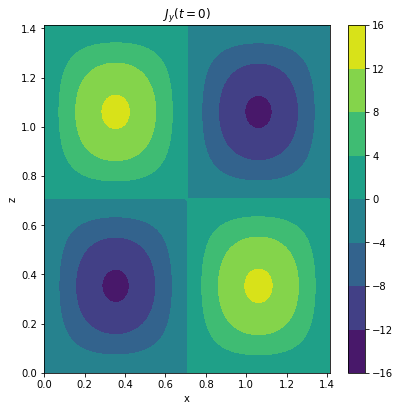

In [19]:
x = np.linspace(0, L, n+1)
z = np.linspace(0, L, n+1)
jy = pxx(psi1,h) + pzz(psi1,h)
plt.figure(figsize=[6.4,6.4])
cont = plt.contourf(x, z, jy)
cbar = plt.colorbar(cont)
plt.xlabel('x')
plt.ylabel('z')
plt.title(r'$J_y(t=0)$')
#plt.savefig('jy0.png')

0
vx: 0.004442882745832556 vz: 0.004442882745832556
px: 0.0 pz: 2.5194733787040236e-16
rho: 1.0000394783953954 0.0
psi: 0.318309886058127 0.318309886058127
1
vx: 0.004441654952204966 vz: 0.3284583551851494
rho: 1.0000789489982365 0.999914731240078
psi: 0.31830988593245335 0.31830988593245335
2
vx: 0.004440602967525885 vz: 0.29273253766599155
rho: 1.000118414921935 0.9998723320842251
psi: 0.3183098858067599 0.3183098858067599
3
vx: 0.004439726760795414 vz: 0.2448174305394198
rho: 1.0001578792774493 0.9998300507954877
psi: 0.31830988568103663 0.31830988568103663
4
vx: 0.004439026377429746 vz: 0.24313709808977482
rho: 1.0001973451759882 0.9997878640284625
psi: 0.3183098855552737 0.3183098855552737
5
vx: 0.004438501939374488 vz: 0.24202626095819263
rho: 1.0002368157317167 0.9997457522386936
psi: 0.318309885429461 0.318309885429461
6
vx: 0.004438153645298249 vz: 0.24094568851287007
rho: 1.0002762940644625 0.9997036991004924
psi: 0.31830988530358856 0.31830988530358856
7
vx: 0.00443798177086

vx: 0.004871346936230217 vz: 0.5592576464682032
rho: 1.007261675059097 0.9961316067913661
psi: 0.31830987683208045 0.31830987683208045
69
vx: 0.005279281937025067 vz: 0.5662825653896807
rho: 1.0073174245191914 0.9959774951920614
psi: 0.318309876670653 0.318309876670653
70
vx: 0.00538920151916554 vz: 0.5732144927053059
rho: 1.0076522827332663 0.9959053380577674
psi: 0.31830987650764986 0.31830987650764986
71
vx: 0.005229489429160658 vz: 0.580050559221366
rho: 1.0078781042501035 0.9959053380577674
psi: 0.31830987634300095 0.31830987634300095
72
vx: 0.005297326404209448 vz: 0.5867879967900308
rho: 1.007960729749465 0.9959269028970321
psi: 0.3183098761766321 0.3183098761766321
73
vx: 0.006359376464895775 vz: 0.5934241473147545
rho: 1.0082761940298022 0.995880943975283
psi: 0.3183098760084645 0.3183098760084645
74
vx: 0.006220717818247446 vz: 0.6002639443415838
rho: 1.008516233389582 0.9956962020648307
psi: 0.3183098758384144 0.3183098758384144
75
vx: 0.005851113994936468 vz: 0.607067556041

138
vx: 0.09463880051327352 vz: 2.6348854710426237
rho: 1.072129308539179 0.9381215166578974
psi: 0.3183098033881943 0.3183098033881943
139
vx: 0.10561526328682552 vz: 2.9011608622347094
rho: 1.0839312987089338 0.9314733295286091
psi: 0.3183097993131988 0.3183097993131988
140
vx: 0.12068665354813633 vz: 3.138184631956279
rho: 1.0973835029442218 0.9243195499477158
psi: 0.31830979556052336 0.31830979556052336
141
vx: 0.1337096922172047 vz: 3.2500097844118288
rho: 1.112068770924611 0.9173408768223282
psi: 0.31830979214417876 0.31830979214417876
142
vx: 0.15304580027589434 vz: 3.0393763032036536
rho: 1.1297598235904294 0.9007005118616789
psi: 0.31830978897541146 0.31830978897541146
143
vx: 0.1660709513848032 vz: 2.2205464161962145
rho: 1.1472552043513147 0.8775804349217593
psi: 0.3183097858265857 0.3183097858265857
144
vx: 0.1920942158700402 vz: 2.224852968759163
rho: 1.1677468386351915 0.8500315553146883
psi: 0.3183097823458624 0.3183097823458624
145
vx: 0.23954249887066348 vz: 2.62250478

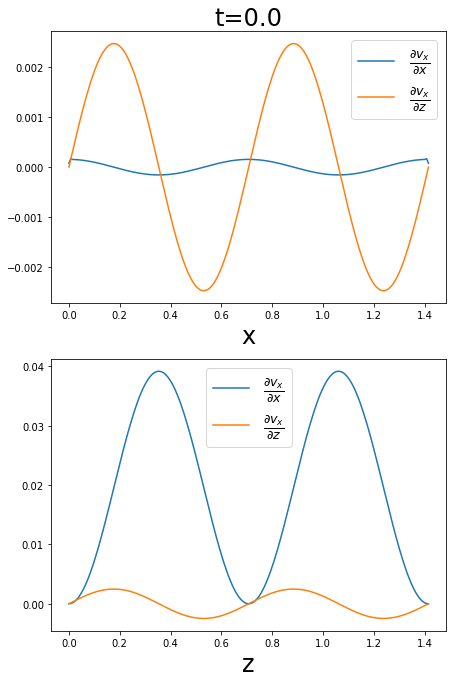

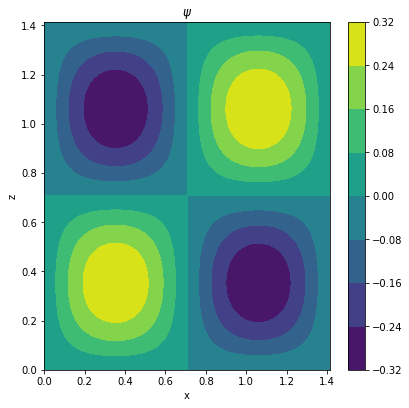

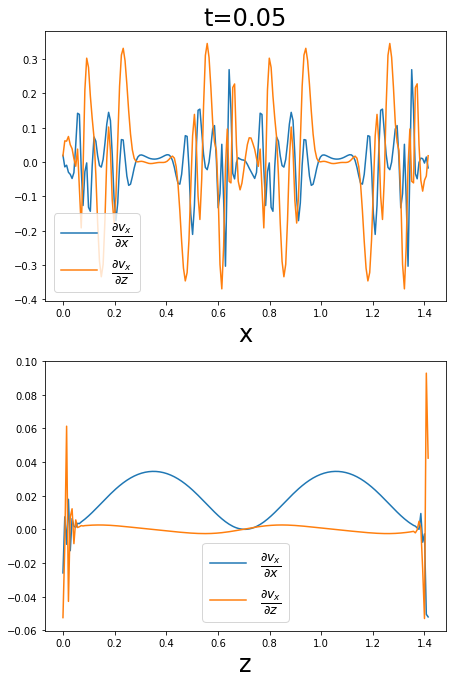

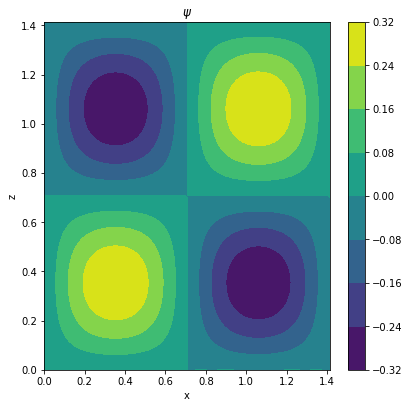

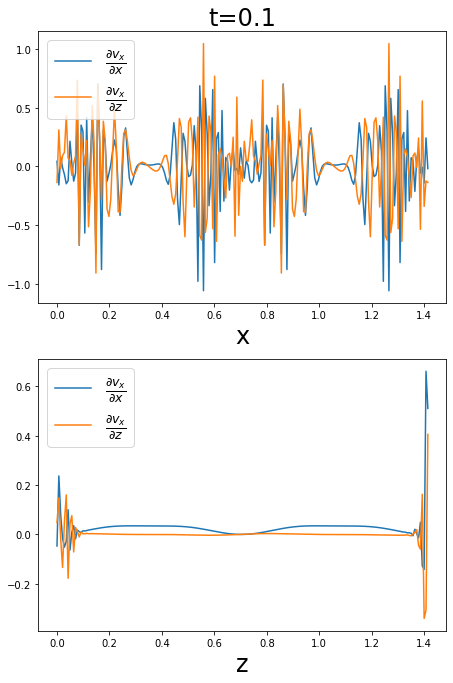

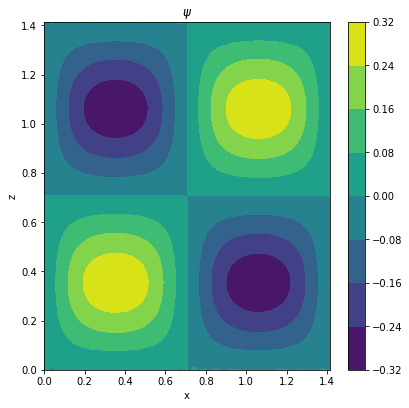

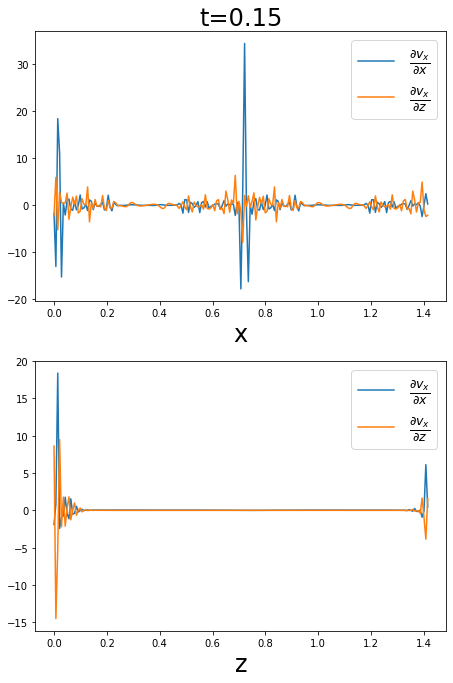

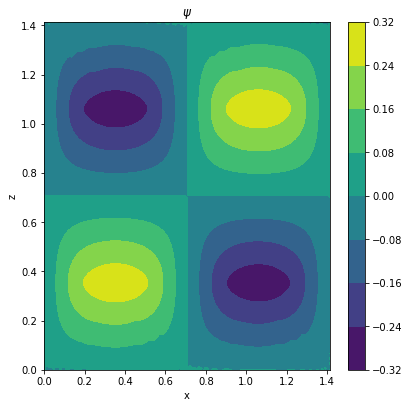

In [32]:
# Leap-frog Stepper
vxtpr = np.zeros([n+2*ng+1, n+2*ng+1]) # temporary array at n+1/2
vztpr = np.zeros([n+2*ng+1, n+2*ng+1]) # temporary array at n+1/2
vx2   = np.zeros([n+2*ng+1, n+2*ng+1]) # updated array at n+1
vz2   = np.zeros([n+2*ng+1, n+2*ng+1]) # updated array at n+1
rho2  = np.zeros([n+2*ng+1, n+2*ng+1]) # updated array at n+1
psi2  = np.zeros([n+2*ng+1, n+2*ng+1]) # updated array at n+1

for k in range(151):
    print(k)
    
    vxtpr[2:-2,2:-2] = vx1[2:-2,2:-2] + f_vx(rho1, vx1, vz1, psi1, h, h, dt*0.5)
    vztpr[2:-2,2:-2] = vz1[2:-2,2:-2] + f_vz(rho1, vx1, vz1, psi1, h, h, dt*0.5)
    print('vx:', np.amax(vxtpr), 'vz:', np.amax(vztpr))
    
    rho2[2:-2,2:-2] = rho1[2:-2,2:-2] + f_rho(rho1, vxtpr, vztpr, h, h, dt, k)
    psi2[2:-2,2:-2] = psi1[2:-2,2:-2] + f_psi(vxtpr, vztpr, psi1, h, h, dt)
    print('rho:', np.amax(rho2), np.amin(rho2))
    print('psi:', np.amax(psi2), np.amax(psi2))
    
    vx2[2:-2,2:-2] = vxtpr[2:-2,2:-2] + f_vx(rho2, vxtpr, vztpr, psi2, h, h, dt*0.5)
    vz2[2:-2,2:-2] = vztpr[2:-2,2:-2] + f_vz(rho2, vxtpr, vztpr, psi2, h, h, dt*0.5)
    
    # Top
    rho2[0]    = rho2[-5]
    rho2[1]    = rho2[-4]
    psi2[0]    = psi2[-5]
    psi2[1]    = psi2[-4]
    vx2[0]     = vx2[-5]
    vx2[1]     = vx2[-4]
    vz2[0]     = vz2[-5]
    vz2[1]     = vz2[-4]
    # Bottom 
    rho2[-2]   = rho2[3]
    rho2[-1]   = rho2[4]
    psi2[-2]   = psi2[3]
    psi2[-1]   = psi2[4]
    vx2[-2]    = vx2[3]
    vx2[-1]    = vx2[4]
    vz2[-2]    = vz2[3]
    vz2[-1]    = vz2[4]
    # Left 
    rho2[:,0]  = rho2[:,-5]  
    rho2[:,1]  = rho2[:,-4]  
    psi2[:,0]  = psi2[:,-5] 
    psi2[:,1]  = psi2[:,-4]
    vx2[:,0]   = vx2[:,-5]  
    vx2[:,1]   = vx2[:,-4]  
    vz2[:,0]   = vz2[:,-5] 
    vz2[:,1]   = vz2[:,-4]
    # Right 
    rho2[:,-2] = rho2[:,3]
    rho2[:,-1] = rho2[:,4]
    psi2[:,-2] = psi2[:,3]
    psi2[:,-1] = psi2[:,4]
    vx2[:,-2]  = vx2[:,3]
    vx2[:,-1]  = vx2[:,4]
    vz2[:,-2]  = vz2[:,3]
    vz2[:,-1]  = vz2[:,4]

    
    # Update the result
    rho1 = rho2
    vx2  = vx2
    vz1  = vz2
    psi1 = psi2
    
    if (k%50==0):
        x = np.linspace(0, L, n+1)
        z = np.linspace(0, L, n+1)
        plt.figure(figsize=[6.4,6.4])
        cont = plt.contourf(x, z, psi1[2:-2,2:-2])
        cbar = plt.colorbar(cont)
        plt.xlabel('x')
        plt.ylabel('z')
        plt.title(r'$\psi$')
        plt.savefig('psi1_'+str(k)+'.png')

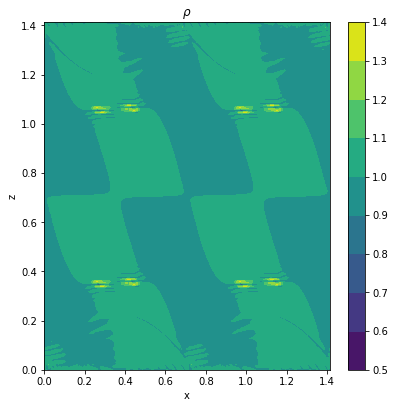

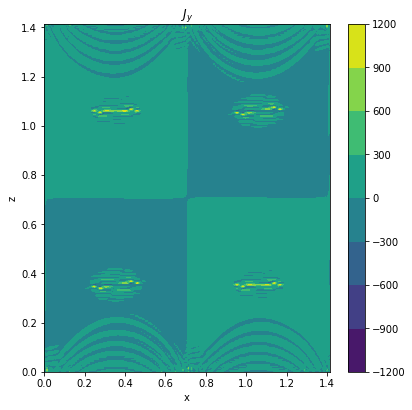

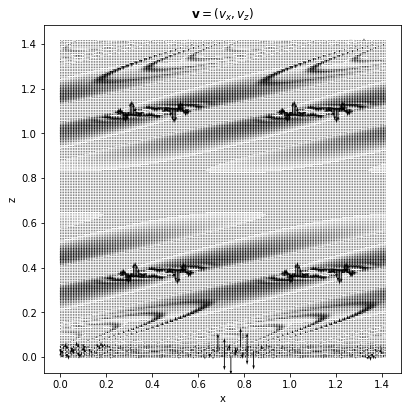

In [13]:
x = np.linspace(0, L, n+1)
z = np.linspace(0, L, n+1)

plt.figure(figsize=[6.4,6.4])
cont = plt.contourf(x, z, rho1[2:-2,2:-2])
cbar = plt.colorbar(cont)
plt.xlabel('x')
plt.ylabel('z')
plt.title(r'$\rho$')
plt.savefig('rho_'+str(k)+'.png')

jy = pxx(psi1,h) + pzz(psi1,h)
plt.figure(figsize=[6.4,6.4])
cont = plt.contourf(x, z, jy)
cbar = plt.colorbar(cont)
plt.xlabel('x')
plt.ylabel('z')
plt.title(r'$J_y$')
plt.savefig('jy_'+str(k)+'.png')

X, Z = np.meshgrid(x,z)
plt.figure(figsize=[6.4,6.4])
plt.quiver(X, Z, vx1, vz1)
plt.xlabel('x')
plt.ylabel('z')
plt.title(r'$\mathbf{v}=(v_x,v_z)$')
plt.savefig('v_'+str(k)+'.png')